### Full Name: Omid Jafaei
### Student ID: 401204268

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import numericalize_tokens_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.functional import numericalize_tokens_from_iterator
from sklearn.model_selection import KFold
import logging
import os
import warnings
warnings.filterwarnings("ignore")


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#الف

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HW4/Q1 Materials/BBBP.csv')

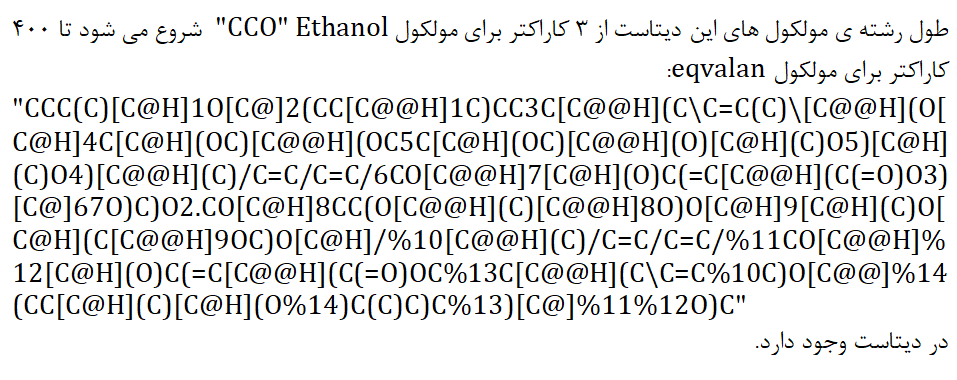

In [ ]:
print('Maximum length: ', df["smiles"].str.len().max())
print('Minimum length: ', df["smiles"].str.len().min())

Maximum length:  400
Minimum length:  3


In [ ]:
df

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


In [ ]:
shuffled_df = df.sample(frac=1, random_state=42)
df = shuffled_df.reset_index(drop=True)

In [ ]:
df

,num,name,p_np,smiles
0,1812,doliracetam,1,C1=CC=CC2=C1C(C(N2CC(N)=O)=O)C3=CC=CC=C3
1,696,methamphetamine,1,CN[C@@H](C)Cc1ccccc1
2,908,quinacillin,0,CC1(C)S[C@@H]2[C@H](NC(=O)c3nc4ccccc4nc3C(O)=O...
3,546,GR94839_L,0,c1(CC(N2[C@H](CN(CC2)C(=O)C)C[N@]2CC[C@H](O)C2...
4,1851,fluradoline,1,C1=C(F)C=CC3=C1C=C(SCCNC)C2=CC=CC=C2O3
...,...,...,...,...
2045,1728,buspirone,1,C1=NC(=NC=C1)N4CCN(CCCCN2C(CC3(CC2=O)CCCC3)=O)CC4
2046,1098,ciprocinonide,1,[C@]34([C@H](C2[C@@](F)([C@@]1(C(=CC(=O)C=C1)[...
2047,1133,cyclindole(ciclindole),1,C1=CC=CC2=C1C3=C([NH]2)CCC(C3)N(C)C
2048,1298,hydrocortisone-aceponate,1,[C@@]4([C@@]3([C@H]([C@H]2[C@@H]([C@@]1(C(=CC(...


In [ ]:
tokenizer = get_tokenizer("basic_english")

def token_gen(text):
    for sent in text:
        tokens = tokenizer(sent)
        yield tokens

In [ ]:
VOCAB_SIZE = 50
MAX_LENGTH = 25

vocab = build_vocab_from_iterator(token_gen(df['smiles']),specials=["<UNK>"],max_tokens=VOCAB_SIZE)
vocab.set_default_index(vocab["<UNK>"])

#تنوع توکن ها

In [ ]:
vocab.get_stoi()

{'cccc': 49,
 '[c@]': 47,
 'c1=o': 46,
 'c=c2': 45,
 'occ': 44,
 'c4c': 42,
 'c[c@h]': 40,
 'c3ccccc3': 39,
 '[o-]': 38,
 'c=cc': 36,
 '[c@@]1': 35,
 'c3=c': 32,
 'c1=cc': 31,
 'c=cc=c2': 30,
 '=cc': 29,
 'c4': 41,
 '[c@@h]': 13,
 '[c@h]': 11,
 'ccn': 33,
 '(': 1,
 'c3': 26,
 'oc': 10,
 'cc': 7,
 'n': 6,
 'c=cc=c3': 37,
 'cc3': 25,
 '[cl-]': 48,
 'c=c1': 34,
 '=o': 4,
 'ccc': 21,
 'c[c@@h]': 43,
 'o': 5,
 '.': 18,
 'c': 3,
 'cl': 9,
 'f': 8,
 '<UNK>': 0,
 'c2': 23,
 'c1': 16,
 'cc1': 14,
 'c1=c': 15,
 ')': 2,
 'cc2': 17,
 'cn': 19,
 'co': 24,
 'coc': 27,
 'nc': 12,
 '=c': 20,
 'c2=c': 22,
 'cc4': 28}

#قسمت ب

ساخت رشته های

padded

In [ ]:
sequence = numericalize_tokens_from_iterator(vocab=vocab,iterator=token_gen(df['smiles']))

token_ids = []
for i in range(len(df)):
    x = list(next(sequence))
    token_ids.append(x)

padded_text = pad_sequence([torch.tensor(x) for x in token_ids], batch_first=True, padding_value=0)
padded_text = padded_text[:,:MAX_LENGTH]
print(padded_text.shape)

torch.Size([2050, 25])


ساخت بردار های

one-hot encoded

In [ ]:
one_hot_encoded = torch.nn.functional.one_hot(padded_text, num_classes=VOCAB_SIZE)
print(one_hot_encoded.shape)
one_hot_encoded = torch.flatten(one_hot_encoded, start_dim=1)
one_hot_encoded.shape

torch.Size([2050, 25, 50])


torch.Size([2050, 1250])

In [ ]:
label =df['p_np'].to_list()
label= torch.tensor(label)

##Baseline Model

In [ ]:
class baseline(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(baseline, self).__init__()


        self.fc1 = nn.Linear(input_size, hidden_size1)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)

        self.output_layer = nn.Linear(hidden_size2, output_size)

        self.activation = nn.Tanh()

    def forward(self, x):
        x = x.float()
        x = self.activation(self.fc1(x))

        x = self.activation(self.fc2(x))

        x = self.output_layer(x)

        return x


Fold 1/5
Validation Accuracy: 0.8439024390243902
Fold 2/5
Validation Accuracy: 0.8292682926829268
Fold 3/5
Validation Accuracy: 0.8292682926829268
Fold 4/5
Validation Accuracy: 0.8292682926829268
Fold 5/5
Validation Accuracy: 0.8390243902439024

Average Cross-Validation Accuracy: 0.8341463414634147


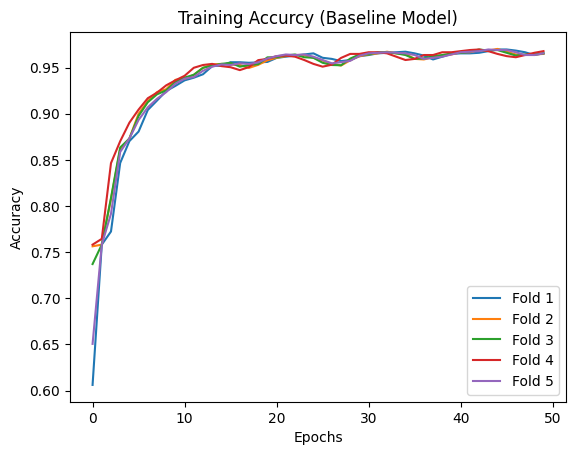

In [ ]:
X_tensor = one_hot_encoded
y_tensor = label
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=45)
fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")

    X_train, X_val = X_tensor[:1640,:], X_tensor[1640:1845,:]
    y_train, y_val = y_tensor[:1640], y_tensor[1640:1845]
    X_val,y_val = X_val.to(device), y_val.to(device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=128)

    model = baseline(input_size=1250, hidden_size1=50, hidden_size2=25, output_size=2).to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    acc = []
    epochs = 50
    model.train()
    for epoch in range(epochs):
        train_loss,train_acc = [],[]
        for t, (X_train, y_train) in enumerate(train_loader):

            X_train,y_train = X_train.to(device), y_train.to(device)

            y_logits = model(X_train)

            loss = loss_fn(y_logits, y_train)

            train_loss.append(loss)
            train_acc.append((y_logits.argmax(1) == y_train).sum().item() / len(y_train))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            del X_train,y_train,y_logits
        acc.append(float(sum(train_acc)/len(train_acc)))
    plt.plot(acc )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accurcy (Baseline Model)')
    plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'], loc='lower right')

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = loss_fn(val_predictions, y_val)
        _, val_preds = torch.max(val_predictions, 1)
        val_accuracy = torch.sum(val_preds == y_val).item() / len(y_val)

    fold_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy}")
avg_accuracy = sum(fold_accuracies) / num_folds
print(f"\nAverage Cross-Validation Accuracy: {avg_accuracy}")


In [ ]:
model.eval()

X_test,y_test = one_hot_encoded[1845:,:],label[1845:]
X_test,y_test = X_test.to(device), y_test.to(device)
y_logits = model(X_test)
loss = loss_fn(y_logits, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {(y_logits.argmax(1) == y_test).sum().item() / len(y_test):.4f}')
del X_test,y_test,y_logits


Test Loss: 0.8198, Test Accuracy: 0.8293


#قسمت ج

##LSTM Model

In [ ]:
num_classes = len(label.unique())

class LSTMClassify(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, BiLSTM = False):
        super().__init__()

        self.hidden_size = hidden_size
        self.BiLSTM = BiLSTM
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=BiLSTM)

        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        if self.BiLSTM == False:
           self.linear1 = nn.Linear(hidden_size, hidden_size)
           self.linear2 = nn.Linear(hidden_size, num_classes)
        else:
           self.linear1 = nn.Linear(2*hidden_size, hidden_size)
           self.linear2 = nn.Linear(hidden_size, num_classes)
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embed.weight.data.uniform_(-initrange, initrange)
        self.lstm.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm.weight_hh_l0.data.uniform_(-initrange, initrange)

        self.linear1.weight.data.uniform_(-initrange, initrange)
        self.linear1.bias.data.zero_()

        self.linear2.weight.data.uniform_(-initrange, initrange)
        self.linear2.bias.data.zero_()

    def forward(self, input):
        embedded = self.embed(input)
        if self.BiLSTM == False:
           h0 = torch.zeros(1, embedded.size(0), self.hidden_size).to(device)
           c0 = torch.zeros(1, embedded.size(0), self.hidden_size).to(device)
        else:
           h0 = torch.zeros(2, embedded.size(0), self.hidden_size).to(device)
           c0 = torch.zeros(2, embedded.size(0), self.hidden_size).to(device)


        output, (hidden, cell) = self.lstm(embedded, (h0, c0))

        output = output[:, -1, :]
        output = self.linear1(output)
        output = self.tanh(output)
        output = self.linear2(output)

        return output


Fold 1/5
Validation Accuracy: 0.8585365853658536
Fold 2/5
Validation Accuracy: 0.8682926829268293
Fold 3/5
Validation Accuracy: 0.848780487804878
Fold 4/5
Validation Accuracy: 0.8341463414634146
Fold 5/5
Validation Accuracy: 0.8878048780487805

Average Cross-Validation Accuracy: 0.8595121951219513


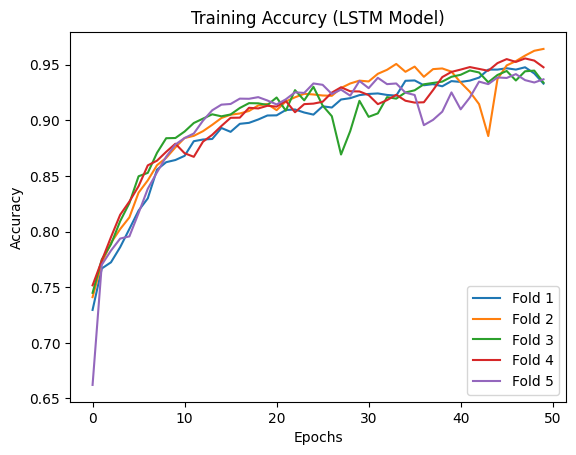

In [ ]:
X_tensor = padded_text
y_tensor = label

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=45)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")


    X_train, X_val = X_tensor[:1640,:], X_tensor[1640:1845,:]
    y_train, y_val = y_tensor[:1640], y_tensor[1640:1845]
    X_val,y_val = X_val.to(device), y_val.to(device)

    model = LSTMClassify(vocab_size=VOCAB_SIZE,embed_dim=100,hidden_size=32).to(device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=128)

    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    acc = []
    epochs = 50
    model.train()
    for epoch in range(epochs):
        train_loss,train_acc = [],[]
        for t, (X_train, y_train) in enumerate(train_loader):

            X_train,y_train = X_train.to(device), y_train.to(device)

            y_logits = model(X_train)

            loss = loss_fn(y_logits, y_train)

            train_loss.append(loss)
            train_acc.append((y_logits.argmax(1) == y_train).sum().item() / len(y_train))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            del X_train,y_train,y_logits
        acc.append(float(sum(train_acc)/len(train_acc)))

    plt.plot(acc )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accurcy (LSTM Model)')
    plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'], loc='lower right')

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = loss_fn(val_predictions, y_val)
        _, val_preds = torch.max(val_predictions, 1)
        val_accuracy = torch.sum(val_preds == y_val).item() / len(y_val)

    fold_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy}")
avg_accuracy = sum(fold_accuracies) / num_folds
print(f"\nAverage Cross-Validation Accuracy: {avg_accuracy}")


In [ ]:
model.eval()

X_test,y_test = padded_text[1845:,:],label[1845:]

X_test,y_test = X_test.to(device), y_test.to(device)
y_logits = model(X_test)
loss = loss_fn(y_logits, y_test)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {(y_logits.argmax(1) == y_test).sum().item() / len(y_test):.4f}')
del X_test,y_test,y_logits

Test Loss: 0.2722, Test Accuracy: 0.9122


#قسمت د

##BiLSTM Model

Fold 1/5
Validation Accuracy: 0.8585365853658536
Fold 2/5
Validation Accuracy: 0.8780487804878049
Fold 3/5
Validation Accuracy: 0.8780487804878049
Fold 4/5
Validation Accuracy: 0.848780487804878
Fold 5/5
Validation Accuracy: 0.8390243902439024

Average Cross-Validation Accuracy: 0.8604878048780489


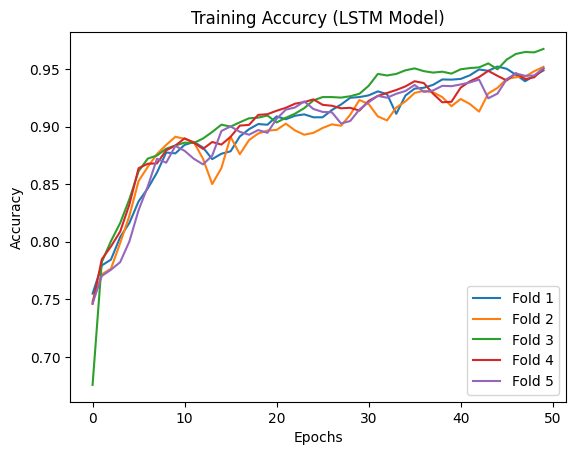

In [ ]:
X_tensor = padded_text
y_tensor = label

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=45)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")


    X_train, X_val = X_tensor[:1640,:], X_tensor[1640:1845,:]
    y_train, y_val = y_tensor[:1640], y_tensor[1640:1845]
    X_val,y_val = X_val.to(device), y_val.to(device)

    model = LSTMClassify(vocab_size=VOCAB_SIZE,embed_dim=100,hidden_size=32, BiLSTM = True).to(device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=128)

    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    acc = []
    epochs = 50
    model.train()
    for epoch in range(epochs):
        train_loss,train_acc = [],[]
        for t, (X_train, y_train) in enumerate(train_loader):

            X_train,y_train = X_train.to(device), y_train.to(device)

            y_logits = model(X_train)

            loss = loss_fn(y_logits, y_train)

            train_loss.append(loss)
            train_acc.append((y_logits.argmax(1) == y_train).sum().item() / len(y_train))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            del X_train,y_train,y_logits

        acc.append(float(sum(train_acc)/len(train_acc)))

    plt.plot(acc )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accurcy (LSTM Model)')
    plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'], loc='lower right')

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = loss_fn(val_predictions, y_val)
        _, val_preds = torch.max(val_predictions, 1)
        val_accuracy = torch.sum(val_preds == y_val).item() / len(y_val)

    fold_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy}")
avg_accuracy = sum(fold_accuracies) / num_folds
print(f"\nAverage Cross-Validation Accuracy: {avg_accuracy}")

In [ ]:
model.eval()

X_test,y_test = padded_text[1845:,:],label[1845:]

X_test,y_test = X_test.to(device), y_test.to(device)
y_logits = model(X_test)
loss = loss_fn(y_logits, y_test)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {(y_logits.argmax(1) == y_test).sum().item() / len(y_test):.4f}')
del X_test,y_test,y_logits

Test Loss: 0.3643, Test Accuracy: 0.9024


#قسمت ه

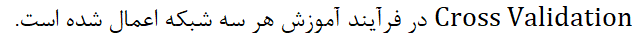

#قسمت و

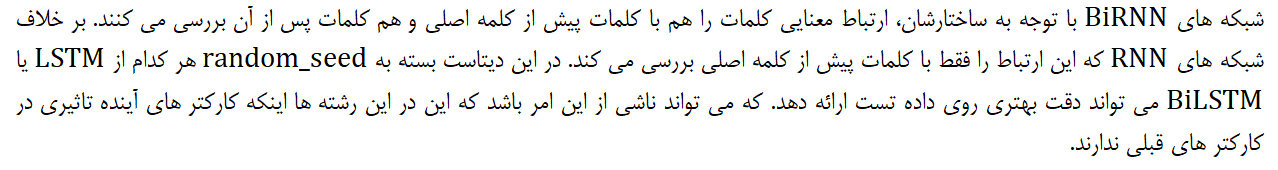